In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
from model.seg_model.model_scales_gate import unet_scales_gate
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*pad*.tif'))
paths_des = sorted(glob.glob(config.dir_des+'/*pad*.tif'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*pad*.tif'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(len(paths_as))
print(paths_as[0])


37
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/scene01_s1as_pad.tif


In [4]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
### 1.1. training scenes selection (in the application, all scenes are used for training.)
tra_scenes, tra_truths = read_normalize(paths_as=paths_as, paths_des=paths_des, \
                      paths_truth=paths_truth, max_bands=config.s1_max, min_bands=config.s1_min)
# ### !!!!extract either ascending or descending image.
# tra_scenes = [s[2:4] for s in tra_scenes]        ## [0:2] -> ascending; [2:4] -> descending

### 1.2. training data loading
# tra_scenes = [tra_scenes[id] for id in config.tra_ids]    ## select the training scenes
# tra_truths = [tra_truths[id] for id in config.tra_ids]
tra_dset = threads_scene_dset(scene_list = tra_scenes, \
                              truth_list = tra_truths, 
                              transforms=config.transforms_tra, 
                              num_thread=30)

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
# !!!extract either ascending or descending image for validation
# for i in range(len(patch_list_val)):
#    for j in range(len(patch_list_val[0][0])):
#       patch_list_val[i][0][j] = patch_list_val[i][0][j][2:4]   ## [0:2] -> ascending; [2:4] -> descending

val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 1110
size of val data: 450


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


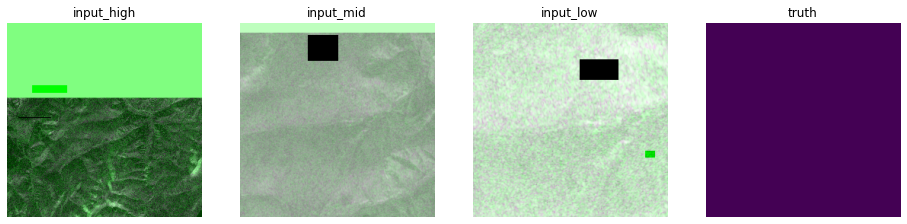

In [6]:
## check training data
for patches, truth in tra_loader:
    patches = patches
    break
patches_ = [patch.to('cpu').detach().numpy().transpose(0,2,3,1).astype(np.float32) for patch in patches]
patches_[0].shape
patches_list = [patches_[0][0],patches_[1][0],patches_[2][0], truth[0].numpy().transpose(1,2,0)]
patches_name = ['input_high','input_mid','input_low','truth']
clip_list = [1,1,1,1]
col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0)]
plt.figure(figsize=(16,5))
imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)


In [7]:
## ------------ Model ------------ ##
## -------- 3. gated multiple scales -------
model = unet_scales_gate(num_bands=4, num_classes=2, \
                    scale_high=2048, scale_mid=512, scale_low=256).to(device)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                          mode='min', factor=0.6, patience=10)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [9]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred,_,_ = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred,_,_ = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            # x_batch = x_batch[2]      # !!!note: x_batch[2] for single-scale model
            y_batch = config.label_smooth(y_batch)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                        optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)         # dynamic adjust learning rate using ReduceLROnPlateau
        # lr_scheduler.step()                 # dynamic adjust learning rate using StepLR

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = [batch.to(device).to(dtype=torch.float32) for batch in x_batch], y_batch.to(device)    
            # x_batch = x_batch[2]          #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: Tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, Val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},Time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device).to(dtype=torch.float32) for patch in patches]
            truth = truth.to(device)
            # pred = model(patches[2])           # !!! note: x[2] for single-scale model
            pred, gate_mid, gate_high = model(patches)            
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            # gate_mid = gate_mid.to('cpu').detach().numpy()
            # gate_high = gate_high.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patches_list = patches + [truth, pred]
            # patches_list = patches + [gate_high[0][0], gate_mid[0][0]] + [truth, pred]
            # ---- plot result
            # print(f'gate_mid:{gate_mid[0,0,0,0]:.2f}, gate_high:{gate_high[0,0,0,0]:.2f}')
            plt.figure(figsize=(14,4))
            # patches_name = ['input_high','input_mid','input_low','gate_high','gate_mid','truth','pred']
            patches_name = ['input_high','input_mid','input_low','truth','pred']
            clip_list = [2,2,2,0,0]
            col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: Tra-> Loss:0.334,Oa:0.974,Miou:0.947, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.6s
Ep2: Tra-> Loss:0.335,Oa:0.958,Miou:0.919, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.7s
Ep3: Tra-> Loss:0.333,Oa:0.978,Miou:0.936, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.4s
Ep4: Tra-> Loss:0.334,Oa:0.967,Miou:0.946, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.2s
Ep5: Tra-> Loss:0.335,Oa:0.977,Miou:0.939, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep6: Tra-> Loss:0.335,Oa:0.957,Miou:0.927, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.1s
Ep7: Tra-> Loss:0.335,Oa:0.980,Miou:0.954, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.9s
Ep8: Tra-> Loss:0.333,Oa:0.989,Miou:0.965, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.2s
Ep9: Tra-> Loss:0.334,Oa:0.986,Miou:0.965, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.7s
Ep10: Tra-> Loss:0.335,Oa:0.977,Miou:0.947, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.0s


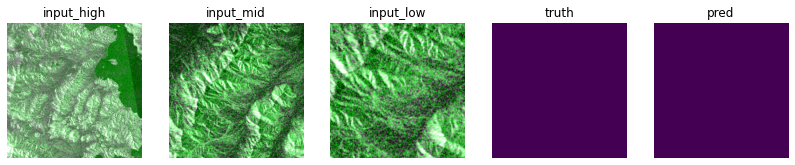

Ep11: Tra-> Loss:0.336,Oa:0.968,Miou:0.937, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep12: Tra-> Loss:0.334,Oa:0.986,Miou:0.961, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep13: Tra-> Loss:0.334,Oa:0.982,Miou:0.956, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.4s
Ep14: Tra-> Loss:0.334,Oa:0.977,Miou:0.954, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.0s
Ep15: Tra-> Loss:0.335,Oa:0.972,Miou:0.942, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep16: Tra-> Loss:0.334,Oa:0.980,Miou:0.937, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep17: Tra-> Loss:0.332,Oa:0.981,Miou:0.950, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.6s
Ep18: Tra-> Loss:0.334,Oa:0.978,Miou:0.944, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.9s
Ep19: Tra-> Loss:0.334,Oa:0.977,Miou:0.947, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep20: Tra-> Loss:0.334,Oa:0.986,Miou:0.967, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.1s


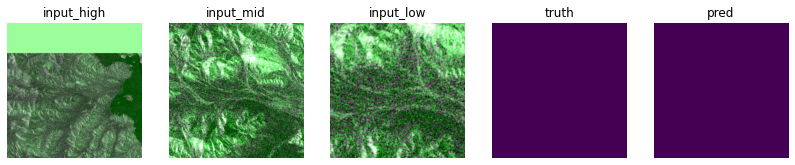

Ep21: Tra-> Loss:0.337,Oa:0.969,Miou:0.934, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep22: Tra-> Loss:0.334,Oa:0.978,Miou:0.955, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.4s
Ep23: Tra-> Loss:0.333,Oa:0.974,Miou:0.942, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.8s
Ep24: Tra-> Loss:0.332,Oa:0.976,Miou:0.955, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.6s
Ep25: Tra-> Loss:0.332,Oa:0.985,Miou:0.964, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.1s
Ep26: Tra-> Loss:0.332,Oa:0.973,Miou:0.944, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep27: Tra-> Loss:0.332,Oa:0.977,Miou:0.950, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:13.9s
Ep28: Tra-> Loss:0.333,Oa:0.980,Miou:0.957, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.8s
Ep29: Tra-> Loss:0.333,Oa:0.985,Miou:0.961, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.4s
Ep30: Tra-> Loss:0.332,Oa:0.968,Miou:0.940, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:15.1s


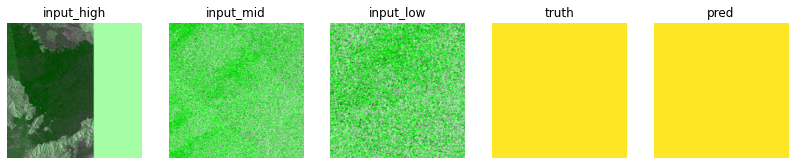

Ep31: Tra-> Loss:0.335,Oa:0.976,Miou:0.947, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.1s
Ep32: Tra-> Loss:0.334,Oa:0.983,Miou:0.960, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.4s
Ep33: Tra-> Loss:0.332,Oa:0.983,Miou:0.955, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.7s
Ep34: Tra-> Loss:0.334,Oa:0.974,Miou:0.948, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep35: Tra-> Loss:0.334,Oa:0.985,Miou:0.953, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.7s
Ep36: Tra-> Loss:0.334,Oa:0.959,Miou:0.942, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep37: Tra-> Loss:0.334,Oa:0.981,Miou:0.955, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.6s
Ep38: Tra-> Loss:0.334,Oa:0.981,Miou:0.961, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep39: Tra-> Loss:0.334,Oa:0.976,Miou:0.950, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.2s
Ep40: Tra-> Loss:0.333,Oa:0.961,Miou:0.931, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.6s


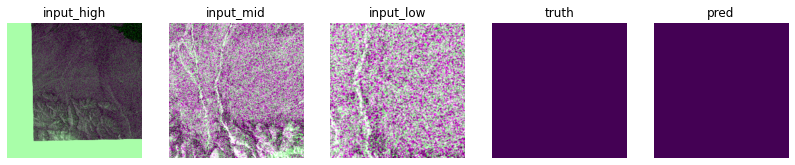

Ep41: Tra-> Loss:0.335,Oa:0.970,Miou:0.938, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep42: Tra-> Loss:0.335,Oa:0.960,Miou:0.925, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.5s
Ep43: Tra-> Loss:0.334,Oa:0.983,Miou:0.962, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.2s
Ep44: Tra-> Loss:0.333,Oa:0.979,Miou:0.949, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.1s
Ep45: Tra-> Loss:0.333,Oa:0.980,Miou:0.953, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.8s
Ep46: Tra-> Loss:0.333,Oa:0.981,Miou:0.951, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.1s
Ep47: Tra-> Loss:0.333,Oa:0.976,Miou:0.953, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep48: Tra-> Loss:0.334,Oa:0.970,Miou:0.945, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.6s
Ep49: Tra-> Loss:0.334,Oa:0.970,Miou:0.938, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.3s
Ep50: Tra-> Loss:0.334,Oa:0.983,Miou:0.954, Val-> Loss:0.120,Oa:0.973,Miou:0.960,Time:14.4s


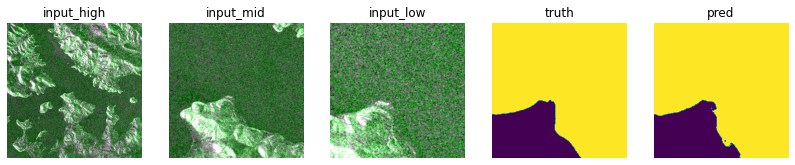

In [14]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,  
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [15]:
# model_name = 'gscales_app_base_3'
# # model_name = 'model_gscales_test_12'
# # model save/load
# path_weights = config.root_proj + '/model/pretrained/apply_to_tibet/' + model_name + '_weights.pth'
# # path_weights = config.root_proj + '/model/pretrain·ed/model_gscales_test/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), path_weights)
# # model.load_state_dict(torch.load(path_weights))



In [12]:
# ## metrics saving
# path_metrics = config.root_proj + '/model/pretrained/gscales_des_test/' + model_name + '_metrics.csv'
# # path_metrics = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')
# metrics_df = pd.read_csv(path_metrics)
